# Analysis of particles in Norwegian Trench
I performed a repeated release every month of particles in the Norwegian  
 trench for every release where simulated for 30 days. The particles are   
 simulated from 1/9/2023 till 30/4/2024. We save the particle location  
 and vorticity of the ocean flow at location particle every hour.    
We performed 3 diferent type of particle simulations.  
1. tracer particles in the norwegian trench released on an hexagonal grid
2. tracer particles displaced released a distance d=100 m in a random direction  
 from the hexagonal grid
3. Inerterial particles, advected with the slow manifold reduced maxey-riley  
equation released from the hexagonal grid


For the analysis I study the difference between the tracer and MR particles  
and compare it with the tracer and displaced tracer particles. Using these    
simulations I want to study whether the difference between tracer particles    
and MR particles in the norwegian trench is because the way the intertial    
term interacts with the flow (eddies) or just because there is a small  
difference and this gets amplified by the large variations in the flowfield  
in the norwegian trench. 

In [47]:
# import needed packages
import numpy as np
import xarray as xr 
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import cartopy.crs as ccrs #for plotting on map
import cartopy as cart
from decimal import Decimal
import plotly.express as px # for 3d plotting
from datetime import datetime, timedelta
from analysis_functions import trajectory_length,  make_PDF, Haversine, running_mean, Haversine_list
import sys
sys.path.append("/nethome/4291387/Maxey_Riley_advection/Maxey_Riley_advection/simulations")
from helper import create_filelist

#set plotstyle
plt.style.use('../python_style_Meike.mplstyle')
colorlist=np.array(['c','purple','orange','navy','red','black','green','violet'])

# set needed constants
Rearth = 6371 * 10**3 # in meters
deg2rad = np.pi / 180.

#set directories and template filenames
base_directory = '/storage/shared/oceanparcels/output_data/data_Meike/MR_advection/NWES/'
basefile_MRSM = (base_directory + 'inertial_SM/{loc}_start{y_s:04d}_{m_s:02d}_{d_s:02d}'
                 '_end{y_e:04d}_{m_e:02d}_{d_e:02d}_RK4_B{B:04d}_tau{tau:04d}.zarr')
basefile_tracer = (base_directory + 'tracer/{loc}_start{y_s:04d}_{m_s:02d}_{d_s:02d}'
                   '_end{y_e:04d}_{m_e:02d}_{d_e:02d}_RK4.zarr')
basefile_tracer_random = (base_directory + 'tracer_random/{loc}_start{y_s:04d}_{m_s:02d}_{d_s:02d}'
                   '_end{y_e:04d}_{m_e:02d}_{d_e:02d}_RK4_d{d:04d}.zarr')

In [55]:
# general settings
runtime =  timedelta(days=30) # timedelta(days=10)
loc = 'norwegian-trench'
B = 0.7
tau = 2.7
displacement = 1# displacement in meters
starttime=datetime(2023, 9, 1, 0, 0, 0, 0)
starttimes=[]
release_timestep=timedelta(days=30)
endtime=datetime(2024, 5, 1, 0, 0, 0, 0)
runtime=timedelta(30)
time=starttime

starttimes = np.array([datetime(2023, 9, 1, 0, 0, 0, 0),
                       datetime(2023, 10, 1, 0, 0, 0, 0),
                       datetime(2023, 11, 1, 0, 0, 0, 0),
                       datetime(2023, 12, 1, 0, 0, 0, 0),
                       datetime(2024, 1, 1, 0, 0, 0, 0),
                       datetime(2024, 2, 1, 0, 0, 0, 0),
                       datetime(2024, 3, 1, 0, 0, 0, 0),
                       datetime(2024, 4, 1, 0, 0, 0, 0)])

# date_new = datetime(2023, 9, 1, 0, 0, 0, 0)
print(starttimes)

[datetime.datetime(2023, 9, 1, 0, 0) datetime.datetime(2023, 10, 1, 0, 0)
 datetime.datetime(2023, 11, 1, 0, 0) datetime.datetime(2023, 12, 1, 0, 0)
 datetime.datetime(2024, 1, 1, 0, 0) datetime.datetime(2024, 2, 1, 0, 0)
 datetime.datetime(2024, 3, 1, 0, 0) datetime.datetime(2024, 4, 1, 0, 0)]


## Import data

In [56]:
nparticles = 1961
chunck_time = 100
data = {}
data[2023] = {}
data[2024] = {}


for starttime in starttimes:
    print(starttime)
    endtime = starttime + runtime
    file_tracer =   basefile_tracer.format(loc=loc,
                                           y_s=starttime.year,
                                           m_s=starttime.month,
                                           d_s=starttime.day,
                                           y_e=endtime.year,
                                           m_e=endtime.month,
                                           d_e=endtime.day)

    data[starttime.year][starttime.month] = xr.open_dataset(file_tracer,
                                                             engine='zarr',
                                                             chunks={'trajectory':nparticles,
                                                                     'obs':chunck_time},
                                                             drop_variables=['B','tau','z'],
                                                             decode_times=False) #,decode_cf=False)

    data[starttime.year][starttime.month] = data[starttime.year][starttime.month].rename({'lon':'lon_tracer', 'lat':'lat_tracer', 'time':'time_tracer','vorticity':'vorticity_tracer'})

    file_MRSM =   basefile_MRSM.format(loc=loc,
                                       y_s=starttime.year,
                                       m_s=starttime.month,
                                       d_s=starttime.day,
                                       y_e=endtime.year,
                                       m_e=endtime.month,
                                       d_e=endtime.day,
                                       B = int(B * 1000), 
                                       tau = int(tau * 1000))
    dsMR = xr.open_dataset(file_MRSM,
                           engine='zarr',
                           chunks={'trajectory':nparticles, 'obs':chunck_time},
                           drop_variables=['B','tau','z'],
                           decode_times=False)  #,decode_cf=False)
    dsMR = dsMR.rename({'lon':'lon_MR', 'lat':'lat_MR',
                        'time':'time_MR', 'vorticity':'vorticity_MR'})
    data[starttime.year][starttime.month] = data[starttime.year][starttime.month].merge(dsMR)


    file_tracer_random =   basefile_tracer_random.format(loc=loc,
                                       y_s=starttime.year,
                                       m_s=starttime.month,
                                       d_s=starttime.day,
                                       y_e=endtime.year,
                                       m_e=endtime.month,
                                       d_e=endtime.day,
                                       d=int(displacement))
    dsrandom = xr.open_dataset(file_tracer_random,
                           engine='zarr',
                           chunks={'trajectory':nparticles, 'obs':chunck_time},
                           drop_variables=['B','tau','z'],
                           decode_times=False)  #,decode_cf=False)
    dsrandom = dsrandom.rename({'lon':'lon_random', 'lat':'lat_random',
                        'time':'time_random', 'vorticity':'vorticity_random'})
    data[starttime.year][starttime.month] = data[starttime.year][starttime.month].merge(dsrandom)

2023-09-01 00:00:00
2023-10-01 00:00:00
2023-11-01 00:00:00
2023-12-01 00:00:00
2024-01-01 00:00:00
2024-02-01 00:00:00
2024-03-01 00:00:00
2024-04-01 00:00:00


## Plot Trajectories

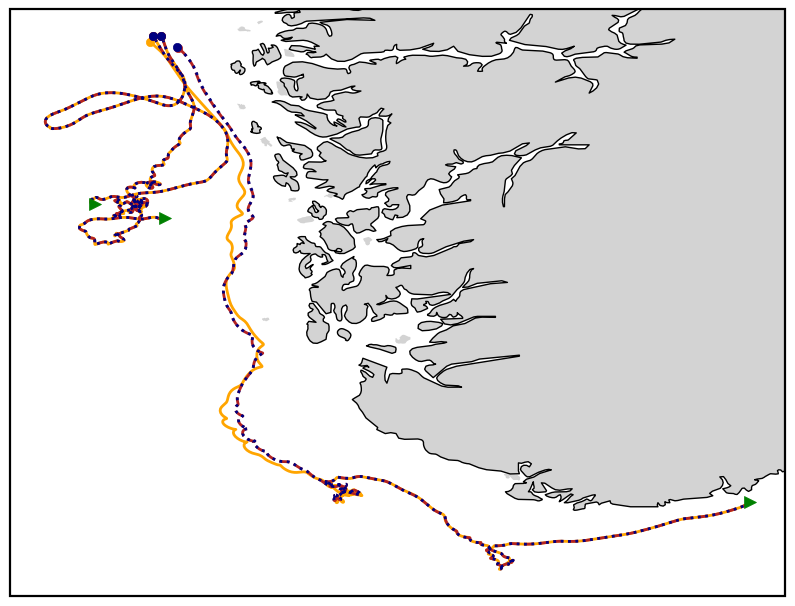

In [102]:
# plot selection of trajectories
year = 2023
month = 9
start = 80
step = 900

fig,ax = plt.subplots(subplot_kw={'projection':ccrs.PlateCarree()})
ax.coastlines()
ax.add_feature(cart.feature.LAND, facecolor='lightgrey')
ax.plot(data[year][month]['lon_tracer'][start::step,0].values,
        data[year][month]['lat_tracer'][start::step,0].values,
        '>',
        color='green',
        zorder=20)
ax.plot(data[year][month]['lon_tracer'][start::step].values.T,
        data[year][month]['lat_tracer'][start::step].values.T,
        '-',
        color='orange');

ax.plot(data[year][month]['lon_MR'][start::step].values.T,
        data[year][month]['lat_MR'][start::step].values.T,
        '--',
        color='firebrick');

ax.plot(data[year][month]['lon_random'][start::step].values.T,
        data[year][month]['lat_random'][start::step].values.T,
        ':',
        color='navy');


ax.plot(data[year][month]['lon_tracer'][start::step].ffill(dim='obs')[:,-1].values.T,
        data[year][month]['lat_tracer'][start::step].ffill(dim='obs')[:,-1].values.T,
        'o',
        markersize=6,
        color='orange');
ax.plot(data[year][month]['lon_MR'][start::step].ffill(dim='obs')[:,-1].values.T,
        data[year][month]['lat_MR'][start::step].ffill(dim='obs')[:,-1].values.T,
        'o',
        markersize=6,
        color='firebrick');
ax.plot(data[year][month]['lon_random'][start::step].ffill(dim='obs')[:,-1].values.T,
        data[year][month]['lat_random'][start::step].ffill(dim='obs')[:,-1].values.T,
        'o',
        markersize=6,
        color='navy');


## Single particle analysis
Characterize:
1. Along track distance
2. Net displacment 

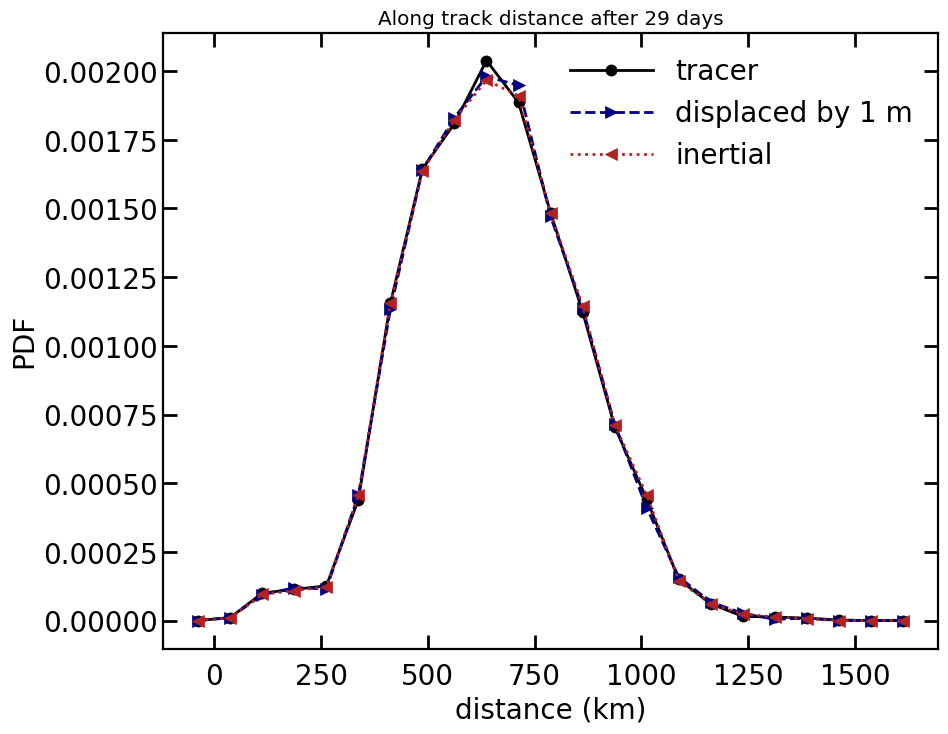

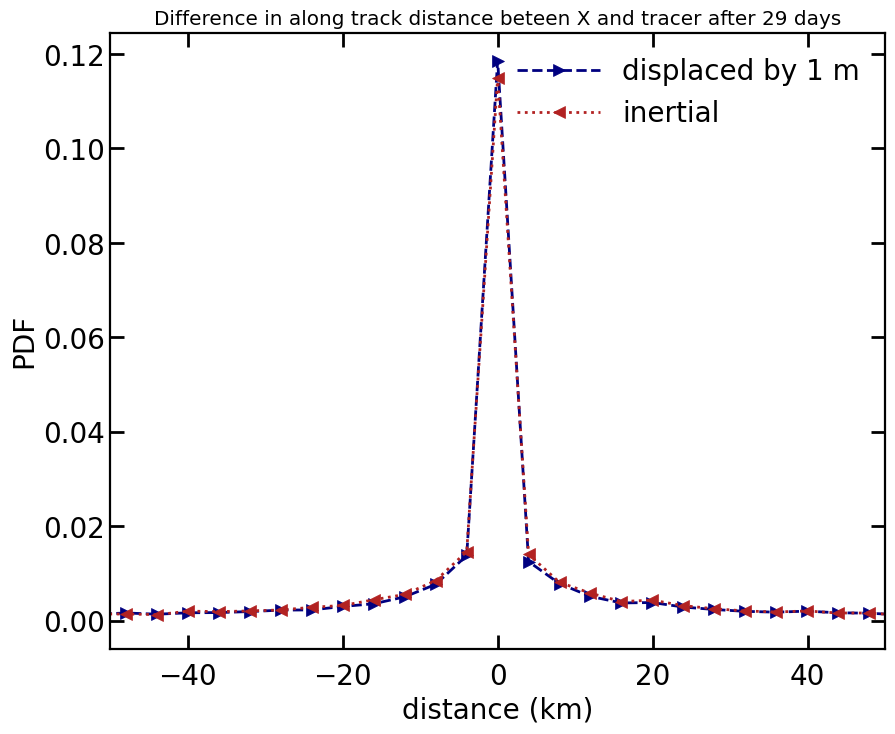

In [60]:
# along track distance
fig,ax=plt.subplots()

tmax = 29*24
array_tracer=np.array([])
array_random=np.array([])
array_MR=np.array([])
array_diff_MR=np.array([])
array_diff_random=np.array([])
i=0
for starttime in starttimes:
    year = starttime.year
    month = starttime.month

    tracer = trajectory_length(data[year][month]['lon_tracer'],data[year][month]['lat_tracer'])
    MR = trajectory_length(data[year][month]['lon_MR'],data[year][month]['lat_MR'])
    random = trajectory_length(data[year][month]['lon_random'],data[year][month]['lat_random'])
    diff_tracer = random - tracer
    diff_MR = MR - tracer
  
    array_tracer=np.concatenate((array_tracer, tracer[:,tmax][~np.isnan(tracer[:,tmax])]))
    array_random=np.concatenate((array_random, random[:,tmax][~np.isnan(random[:,tmax])]))
    array_MR=np.concatenate((array_MR, MR[:,tmax][~np.isnan(MR[:,tmax])]))
    array_diff_MR=np.concatenate((array_diff_MR, diff_MR[:,tmax][~np.isnan(diff_MR[:,tmax])]))
    array_diff_random=np.concatenate((array_diff_random, diff_tracer[:,tmax][~np.isnan(diff_tracer[:,tmax])]))
bins_tracer, pdf_tracer = make_PDF(array_tracer,20, norm =True, min = 0, max = 1500)
bins_random, pdf_random = make_PDF(array_random,20, norm =True, min = 0, max = 1500)
bins_MR, pdf_MR = make_PDF(array_MR,20, norm =True, min = 0, max = 1500)
ax.plot(bins_tracer,pdf_tracer,'-o',color='k')
ax.plot(bins_random,pdf_random,'-->',color='navy')
ax.plot(bins_MR,pdf_MR,':<',color='firebrick')
ax.set_ylabel("PDF")
ax.set_xlabel("distance (km)")
ax.set_title('Along track distance after 29 days')
ax.legend(['tracer','displaced by 1 m', 'inertial'])

fig2, ax2=plt.subplots()
bins_random, pdf_random = make_PDF(array_diff_random,501, norm =True,min=-1000,max=1000)
bins_MR, pdf_MR = make_PDF(array_diff_MR,501, norm =True,min=-1000,max=1000)
ax2.plot(bins_random,pdf_random,'-->',color='navy')
ax2.plot(bins_MR,pdf_MR,':<',color='firebrick')
ax2.set_xlim(-50,50)
ax2.set_title('Difference in along track distance beteen X and tracer after 29 days')
ax2.set_ylabel("PDF")
ax2.set_xlabel("distance (km)")
ax2.legend(['displaced by 1 m','inertial'])

## 2 particle analaysis
- difference between particle pairs (tracer - inertial, tracer - random displaced, intertial - random displaced) more than cmax (1km)
- Relative dispersion

In [69]:
## difference between particle pairs and relative dispersion

i=0


legend=[]
D_MR=np.zeros(800)
D_MR_per_month=[]
D_random=np.zeros(800)
D_MR_random=np.zeros(800)
for starttime in starttimes:
    print(starttime)
    year = starttime.year
    month = starttime.month
    dist_tracer_MR = Haversine(data[year][month]['lon_tracer'],data[year][month]['lat_tracer'],
                               data[year][month]['lon_MR'], data[year][month]['lat_MR'])
    da_dist = xr.DataArray(dist_tracer_MR, dims=['trajectory','obs'])
    data[year][month]=data[year][month].assign(dist_tracer_MR = da_dist)
    dist_tracer_random = Haversine(data[year][month]['lon_tracer'],data[year][month]['lat_tracer'],
                               data[year][month]['lon_random'], data[year][month]['lat_random'])
    da_dist_random = xr.DataArray(dist_tracer_random, dims=['trajectory','obs'])
    data[year][month]=data[year][month].assign(dist_tracer_random = da_dist_random)
    dist_MR_random = Haversine(data[year][month]['lon_MR'],data[year][month]['lat_MR'],
                               data[year][month]['lon_random'], data[year][month]['lat_random'])
    da_dist_MR_random = xr.DataArray(dist_MR_random, dims=['trajectory','obs'])
    data[year][month]=data[year][month].assign(dist_MR_random = dist_MR_random)

    # relative dispersion
    d_mr=(da_dist**2).mean(dim='trajectory',skipna=True).values
    D_MR+=d_mr
    D_MR_per_month.append(d_mr)

    D_random+=(da_dist_random**2).mean(dim='trajectory',skipna=True).values
    D_MR_random+=(da_dist_MR_random**2).mean(dim='trajectory',skipna=True).values
D_MR/=starttimes.size
D_random/=starttimes.size
D_MR_random/=starttimes.size






2023-09-01 00:00:00
2023-10-01 00:00:00
2023-11-01 00:00:00
2023-12-01 00:00:00
2024-01-01 00:00:00
2024-02-01 00:00:00
2024-03-01 00:00:00
2024-04-01 00:00:00


In [70]:
D_MR_per_month=np.asarray(D_MR_per_month)


(8, 800)

Text(0.5, 1.0, 'dist difference inertial and displaced particle > 1 km')

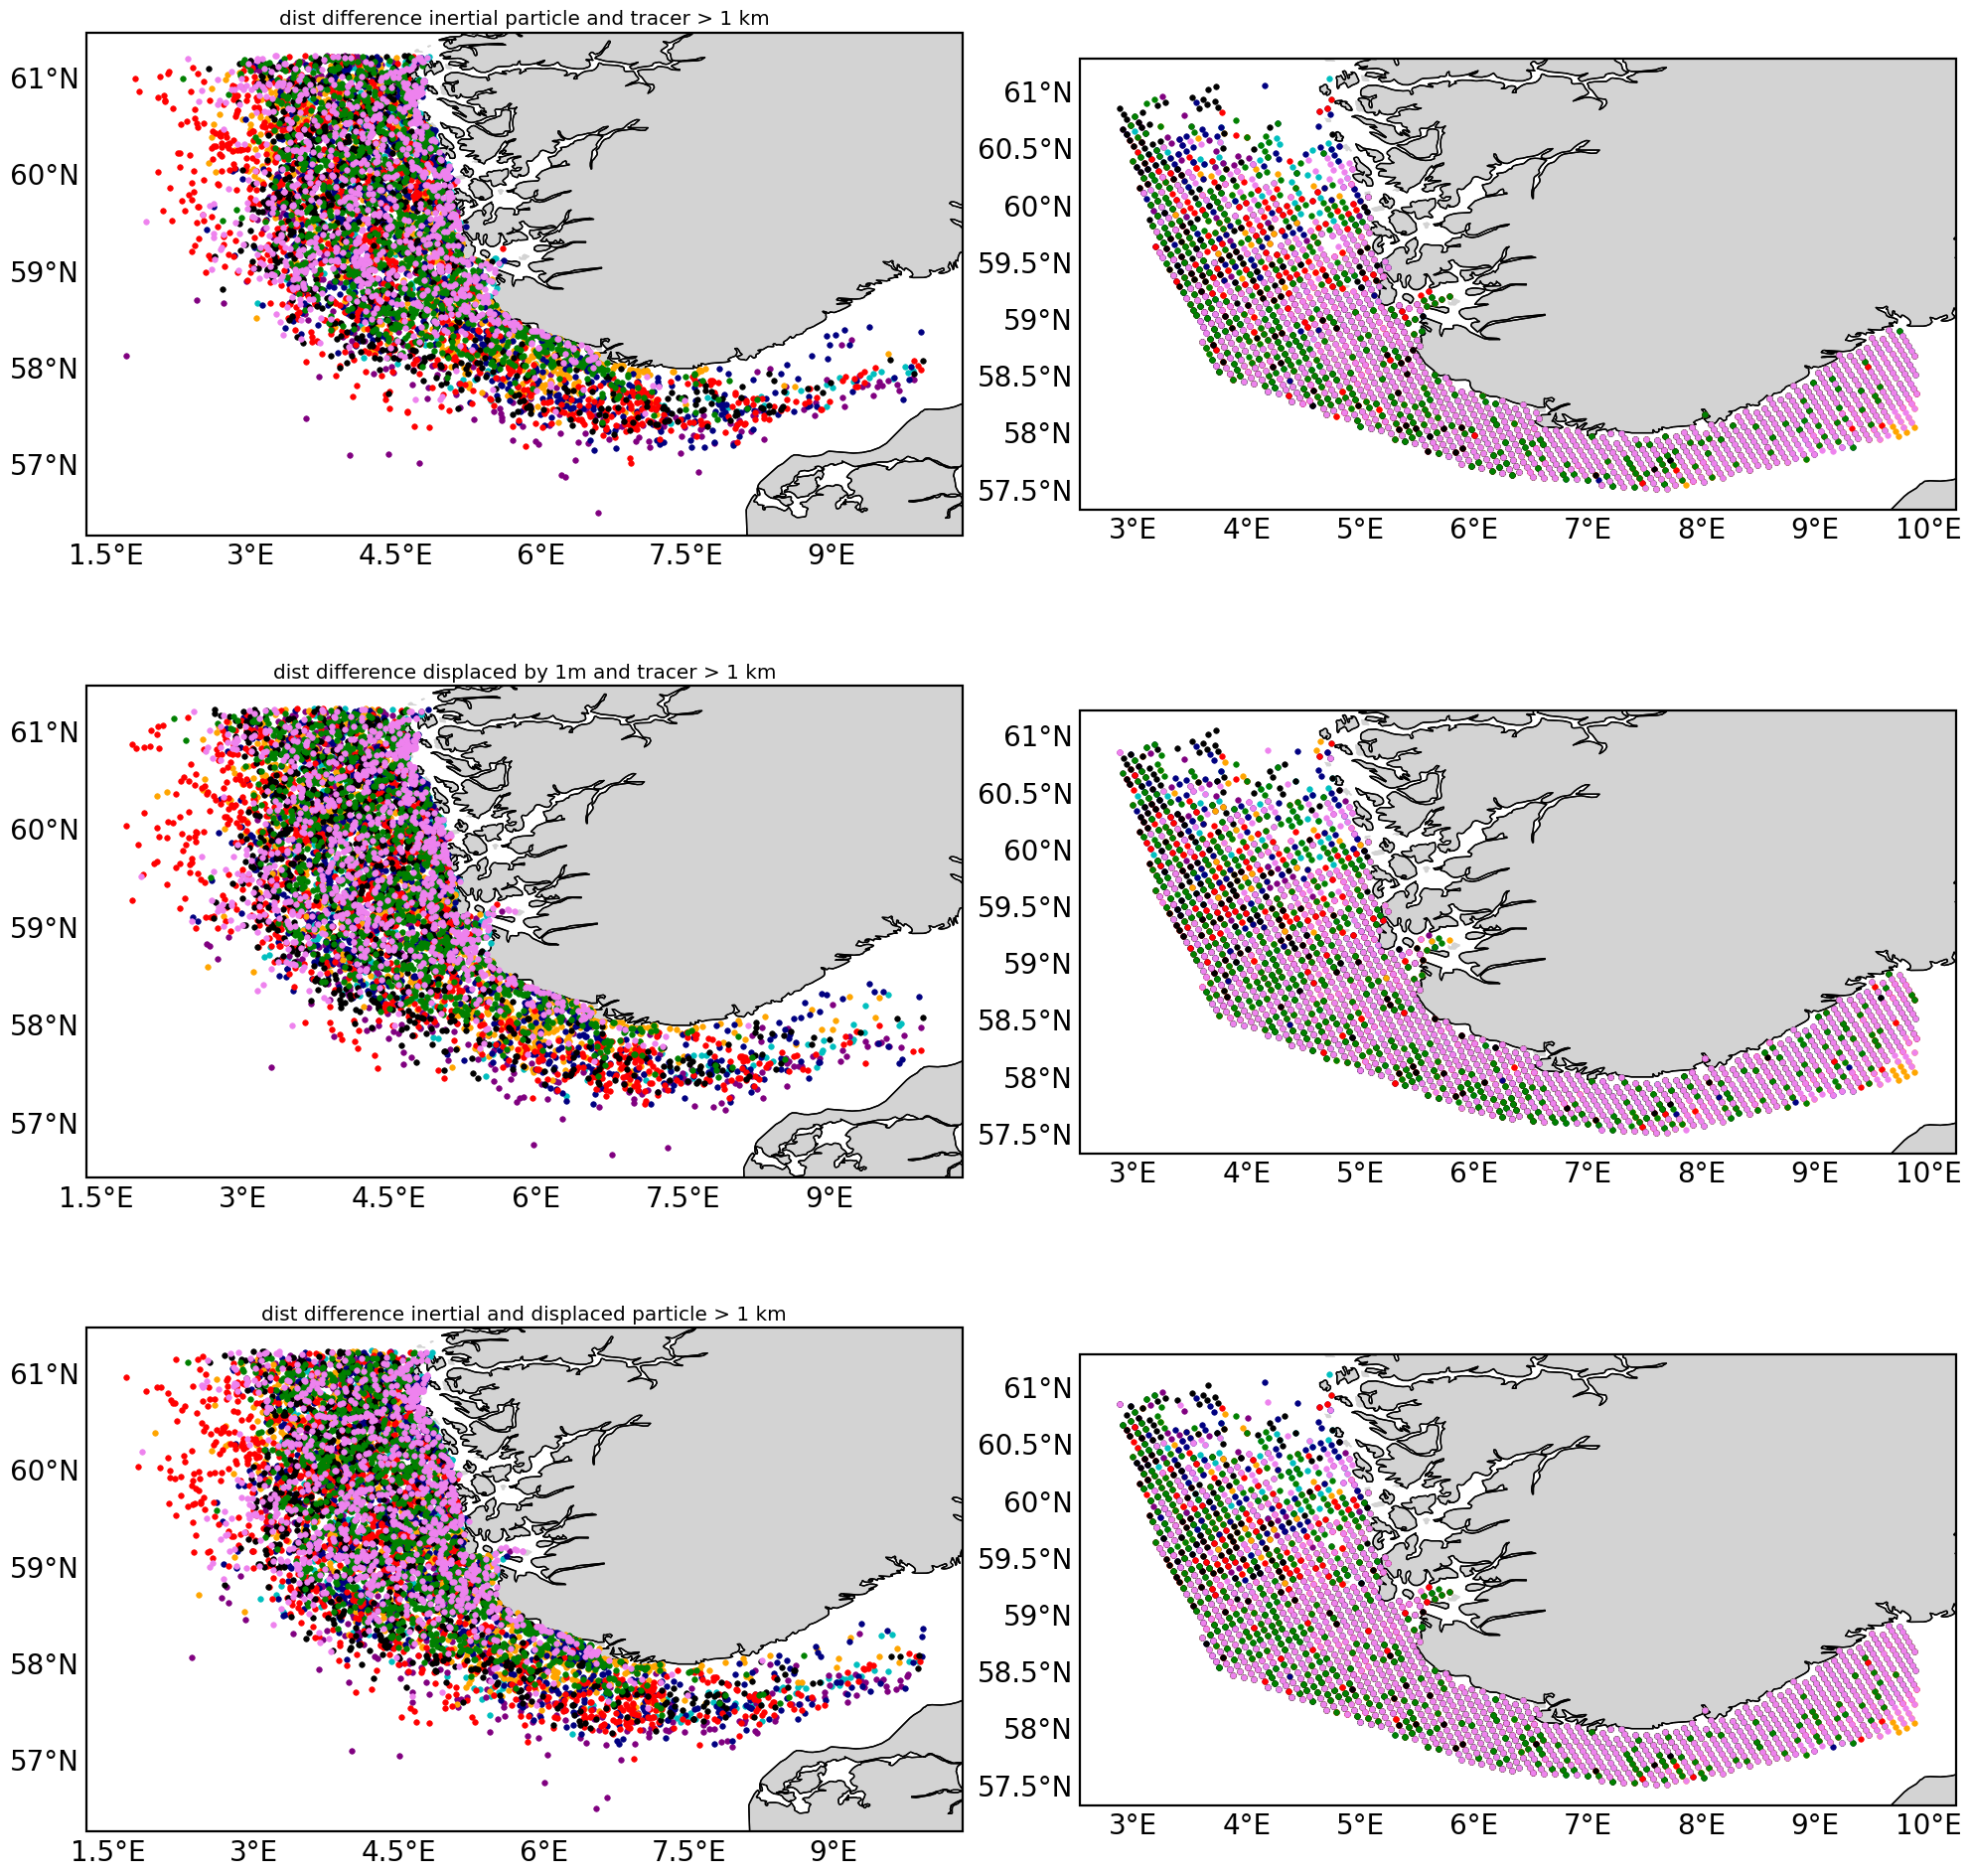

In [66]:
# plot trajectories particles when it is for the first time > cmax 
frac_list_MR=[]
frac_list_random=[]
frac_list_MR_random=[]
cmax = 1#0.05#0.1 # km
i=0
fig,axs=plt.subplots(3,2,figsize=(20,20),
                     subplot_kw={'projection':ccrs.PlateCarree()})
for starttime in starttimes:
    
    # print(starttime)
    year = starttime.year
    month = starttime.month
    
    # make dataset where only values where difference bigger than cmax are saved
    ds_cmax_MR = data[year][month].where(data[year][month].dist_tracer_MR > cmax)
    ds_cmax_random = data[year][month].where(data[year][month].dist_tracer_random > cmax)
    ds_cmax_MR_random = data[year][month].where(data[year][month].dist_MR_random > cmax)

    first_lon_MR = ds_cmax_MR.lon_tracer.bfill(dim='obs')[:,0]
    first_lat_MR = ds_cmax_MR.lat_tracer.bfill(dim='obs')[:,0]
    first_lon_random = ds_cmax_random.lon_tracer.bfill(dim='obs')[:,0]
    first_lat_random = ds_cmax_random.lat_tracer.bfill(dim='obs')[:,0]
    first_lon_MR_random = ds_cmax_MR_random.lon_tracer.bfill(dim='obs')[:,0]
    first_lat_MR_random = ds_cmax_MR_random.lat_tracer.bfill(dim='obs')[:,0]
    #use bfill to plot first nonnan value
    axs[0,0].plot(first_lon_MR, first_lat_MR,'.',color=colorlist[i])
    axs[1,0].plot(first_lon_random, first_lat_random,'.',color=colorlist[i])
    axs[2,0].plot(first_lon_MR_random, first_lat_MR_random,'.',color=colorlist[i])
    
    select_MR = ~np.isnan(first_lon_MR.values)  
    select_random = ~np.isnan(first_lon_random.values)  
    select_MR_random = ~np.isnan(first_lon_MR_random.values)  
    index_select_MR = np.arange(0,nparticles,1)[select_MR]
    index_select_random = np.arange(0,nparticles,1)[select_random]
    index_select_MR_random = np.arange(0,nparticles,1)[select_MR_random]

    start_lon_MR = data[year][month].lon_tracer[index_select_MR,0]
    start_lat_MR = data[year][month].lat_tracer[index_select_MR,0]
    start_lon_random = data[year][month].lon_tracer[index_select_random,0]
    start_lat_random = data[year][month].lat_tracer[index_select_random,0]
    start_lon_MR_random = data[year][month].lon_tracer[index_select_MR_random,0]
    start_lat_MR_random = data[year][month].lat_tracer[index_select_MR_random,0]
    axs[0,1].plot(start_lon_MR,start_lat_MR,'.',color=colorlist[i])
    axs[1,1].plot(start_lon_random,start_lat_random,'.',color=colorlist[i])
    axs[2,1].plot(start_lon_MR_random,start_lat_MR_random,'.',color=colorlist[i])



    ntotal_MR=ds_cmax_MR.lon_tracer.bfill(dim='obs')[:,0].dropna('trajectory').shape[0]
    ntotal_random=ds_cmax_random.lon_tracer.bfill(dim='obs')[:,0].dropna('trajectory').shape[0]
    ntotal_MR_random=ds_cmax_MR_random.lon_tracer.bfill(dim='obs')[:,0].dropna('trajectory').shape[0]

    frac_list_MR.append(ntotal_MR/nparticles)
    frac_list_random.append(ntotal_random/nparticles)
    frac_list_MR_random.append(ntotal_MR_random/nparticles)
    i+=1
for row in axs:   
    for ax in row: 
        ax.coastlines()
        ax.add_feature(cart.feature.LAND,facecolor='lightgrey')
        ax.coastlines()
        ax.add_feature(cart.feature.LAND,facecolor='lightgrey')
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                        linewidth=0, color='gray', alpha=0.5, linestyle='--')
        gl.top_labels = False
        gl.right_labels = False
        gl.xlabel_style = {'size': 20}
        gl.ylabel_style =  {'size': 20}

fig.tight_layout()
axs[0,0].set_title(f'dist difference inertial particle and tracer > {cmax} km')
axs[1,0].set_title(f'dist difference displaced by 1m and tracer > {cmax} km')
axs[2,0].set_title(f'dist difference inertial and displaced particle > {cmax} km')


cmax = 1 km


Text(0, 0.5, 'fraction of particles that \n is seperated more than 1 km')

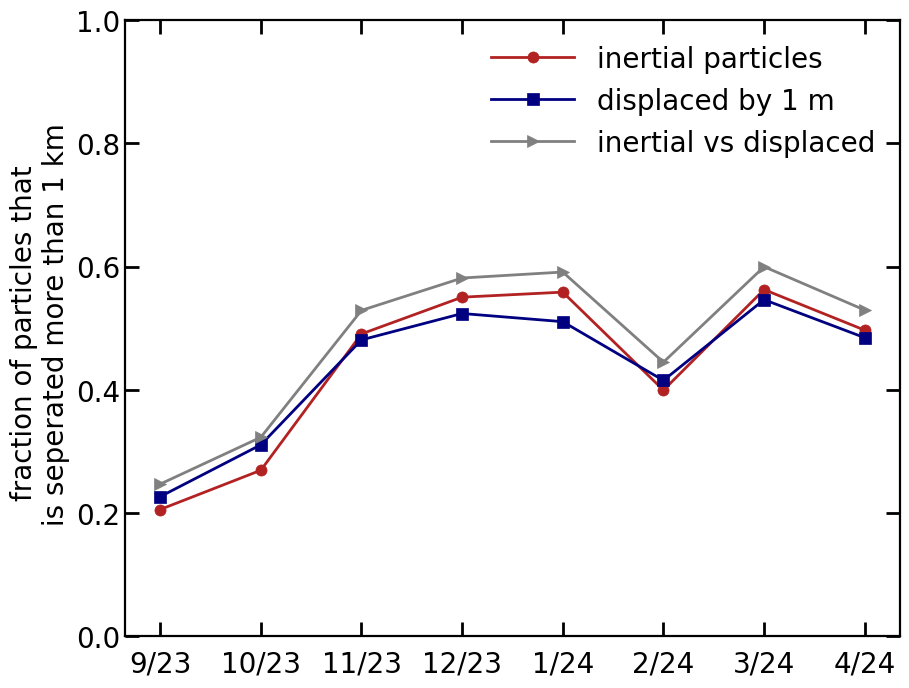

In [68]:
#fraction of particles that is seperated more than cmax
print(f'cmax = {cmax} km')
fig,ax=plt.subplots()
frac_list_MR = np.asarray(frac_list_MR)
frac_list_random = np.asarray(frac_list_random)
frac_list_MR_random = np.asarray(frac_list_MR_random)

dates=[]
for starttime in starttimes:
    date=f'{starttime.month}/{starttime.year-2000}'
    dates.append(date)

ax.plot(dates,frac_list_MR,'-o',color='firebrick')
ax.plot(dates,frac_list_random,'-s',color='navy')
ax.plot(dates,frac_list_MR_random,'->',color='grey')
ax.set_ylim(0,1)
ax.legend(['inertial particles', f'displaced by {displacement} m', 'inertial vs displaced'])
ax.set_ylabel(f'fraction of particles that \n is seperated more than {cmax} km')

800


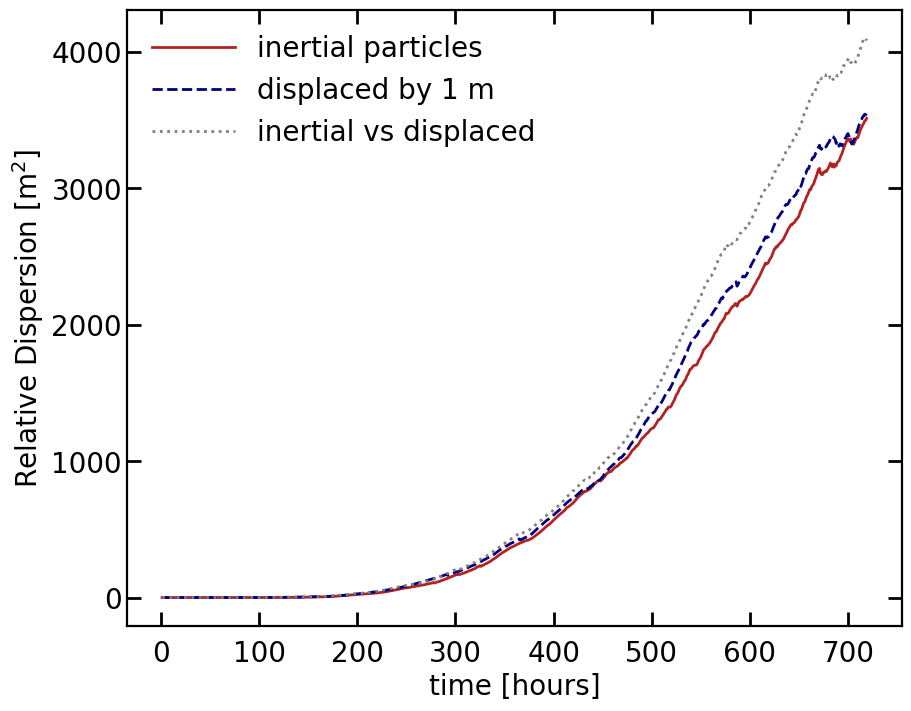

In [81]:
tlist=np.arange(0,D_MR.size,1)
print(D_MR.size)
fig,ax=plt.subplots()
ax.plot(tlist[1:720],D_MR[1:720],'-',color='firebrick')
ax.plot(tlist[1:720],D_random[1:720],'--',color='navy')
ax.plot(tlist[1:720],D_MR_random[1:720],':',color='grey')
# ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_ylabel('Relative Dispersion [m$^2$]')
ax.set_xlabel('time [hours]')
ax.legend(['inertial particles', f'displaced by {displacement} m', 'inertial vs displaced'])

Text(0.5, 1.0, 'Inertial vs tracer particles per month')

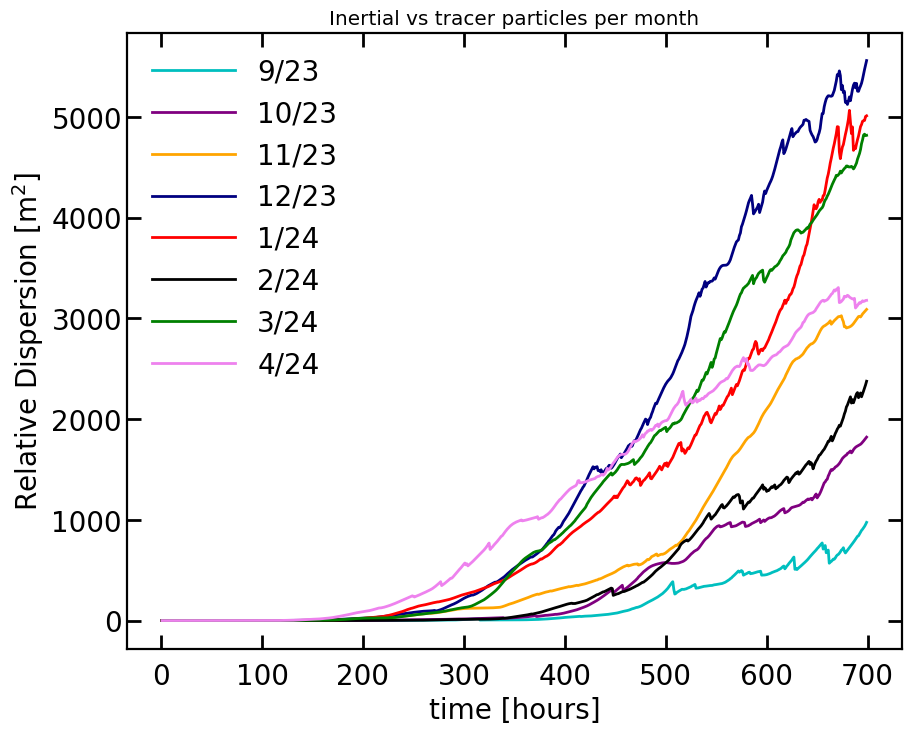

In [80]:
fig, ax =plt.subplots()
tlist=np.arange(0,D_MR.size,1)
legendlist=[]
i=0
for starttime in starttimes:
    ax.plot(tlist[1:700],D_MR_per_month[i][1:700],color=colorlist[i])
    date=f'{starttime.month}/{starttime.year-2000}'
    legendlist.append(date)
    i+=1
# ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_ylabel('Relative Dispersion [m$^2$]')
ax.set_xlabel('time [hours]')
ax.legend(legendlist)
ax.set_title('Inertial vs tracer particles per month')


### Vorticity at particle


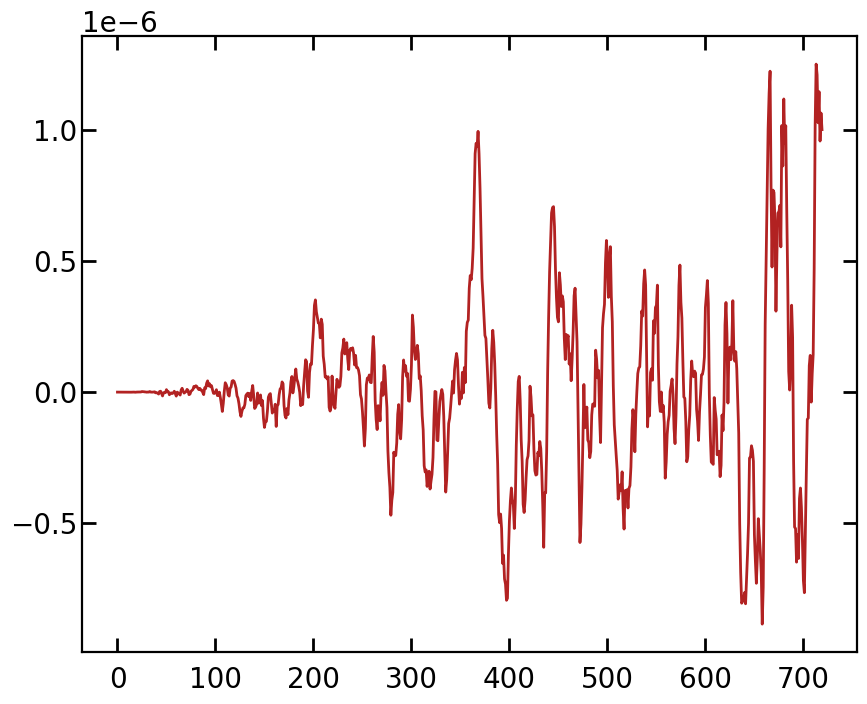

In [82]:
fig,ax=plt.subplots()
i=0
mean_vorticity_difference_MR=np.zeros(800)
mean_vorticity_difference_tracer=np.zeros(800)
for starttime in starttimes:
    year= starttime.year
    month = starttime.month
    vorticity_difference_MR_per_month=(data[year][month].vorticity_MR-data[year][month].vorticity_tracer).mean(dim='trajectory',skipna=True).values
    mean_vorticity_difference_MR+=vorticity_difference_MR_per_month
    i+=1

ax.plot(mean_vorticity_difference_MR/i,color='firebrick')


### Density plot
try to make vonoroi/delany probabilitiy distribution/density plot
or also hexagonal bins plot (1 level higher than release?)
(nice thing about hexagonal bins is that you can use it to plot difference in density)

In [83]:
# needed 
from srai.regionalizers import VoronoiRegionalizer, geocode_to_region_gdf

## 

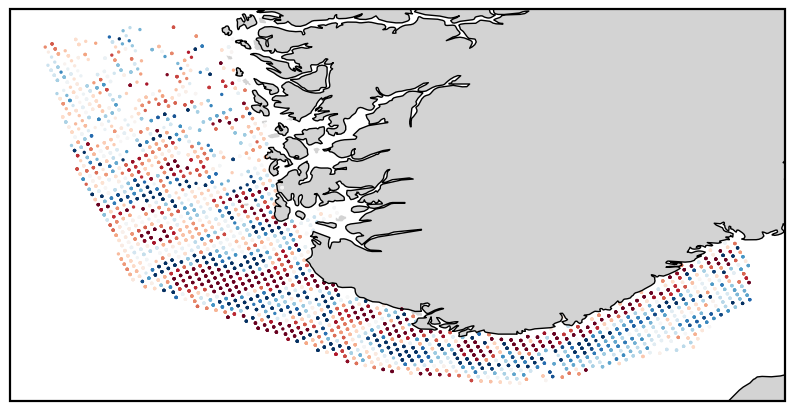

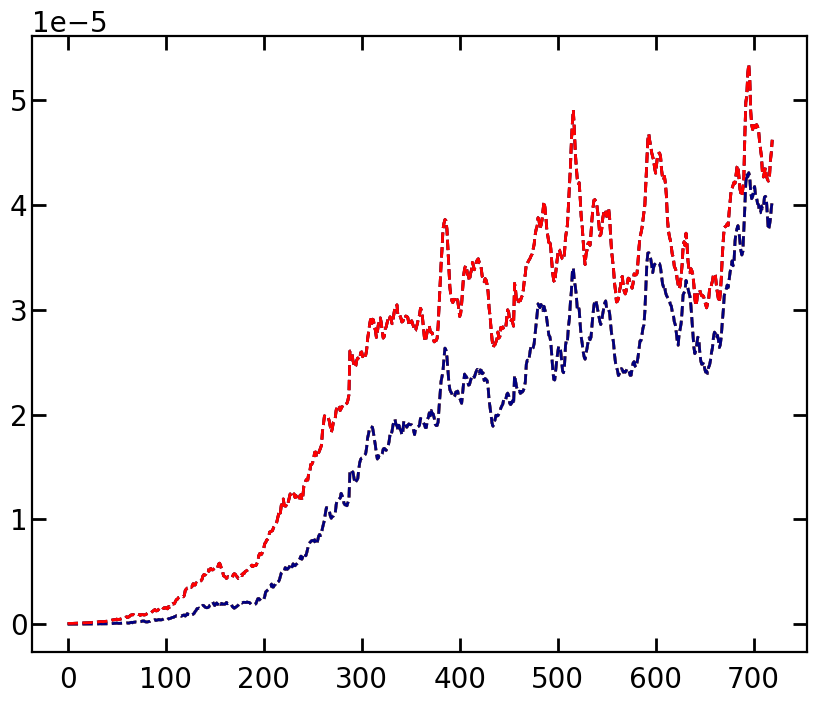

In [106]:
# fig,ax = plt.subplots(subplot_kw={'projection':ccrs.PlateCarree()})
# fig1,ax1=plt.subplots()
# year = 2023
# month = 12
# cmax = 0.1
# for day in range(1,5,1):
#     ds_cmax = data[year][month].where(data[year][month].dist_tracer_MR > cmax)
#     select=~np.isnan(first_lon.values)  
#     first_lon = ds_cmax.lon_tracer.bfill(dim='obs')[:,0]
#     index_select = np.arange(0,nparticles,1)[select]
    
#     # sc=ax.scatter(data[year][month].lon_tracer[:,0].values, data[year][month].lat_tracer[:,0].values,s=2,c=data[year][month].vorticity_tracer[:,0].values,cmap='RdBu',vmin=-0.0005,vmax=0.0005)
#     sc=ax.scatter(data[year][month].lon_tracer[index_select,0].values, data[year][month].lat_tracer[index_select,0].values,s=2,c=data[year][month].vorticity_tracer[index_select,0].values,cmap='RdBu',vmin=-0.0001,vmax=0.0001)

#     # ax1.plot(abs(ds_cmax.vorticity_tracer-ds_cmax.vorticity_
#     # MR).mean(dim='trajectory'),'--',color=colorlist[day-1])
#     # ax1.plot(,'-',color=colorlist[day-1])
#     ax1.plot(abs(data[year][month].vorticity_tracer-data[year][month].vorticity_MR).mean(dim='trajectory'),'--',color=colorlist[day-1])
#     ax1.plot(abs(data[year][month].vorticity_tracer-data[year][month].vorticity_random).mean(dim='trajectory'),'--',color=colorlist[day])
#     # ax1.plot(abs(data[year][month].vorticity_MR).mean(dim='trajectory'),'-',color=colorlist[day])

# ax.coastlines()
# ax.add_feature(cart.feature.LAND,facecolor='lightgrey')

In [ ]:
# along track displacement
